# Captioning Images with Visual Attention
This notebook **writes captions for images** by building and training a transformer model. It also features my cat.

This is a **Lab** I followed from Google's [Generative AI Learning Path](https://www.cloudskillsboost.google/paths/118)

<br>

If opened in Google Colab:
*   Connect to a GPU under Edit->Notebook settings->Hardware accelerator->GPU

This model takes in images and returns a caption of what's happening in the images. It works end-to-end, meaning you pass in the images to the model directly. The large COCO dataset is used for training.

Code is from the course lab, however all code comments and other text are from me!

# Setting up the environment

In [ ]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
  GRU,
  Add,
  AdditiveAttention,
  Attention,
  Concatenate,
  Dense,
  Embedding,
  LayerNormalization,
  Reshape,
  StringLookup,
  TextVectorization,
)

print(tf.version.VERSION)

2.12.0


# Preparing the dataset
We'll use the pretrained model InceptionResNetV2 from `tf.keras.applications` to format our COCO 2014 training data.

In [ ]:
# These control accuracy and speed of model
VOCAB_SIZE = 20000  # Using fewer words will reduce training time
ATTENTION_DIM = 512  # Size of the dense layer in Attention
WORD_EMBEDDING_DIM = 128

# InceptionResNetV2 accepts (299, 299, 3) sized images as input
# and returns (8, 8, 1536) sized features
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
  include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 [==============================] - 1s 0us/step


# Preprecessing the dataset

In [ ]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000

def get_image_label(example):
  """
  Formats image data into a dictionary
  """
  caption = example["captions"]["text"][0]
  img = example["image"]
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  img = img / 255
  return {"image_tensor": img, "caption": caption}

# Load the dataset
trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)
trainds = trainds.map(
  get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Examples from the dataset

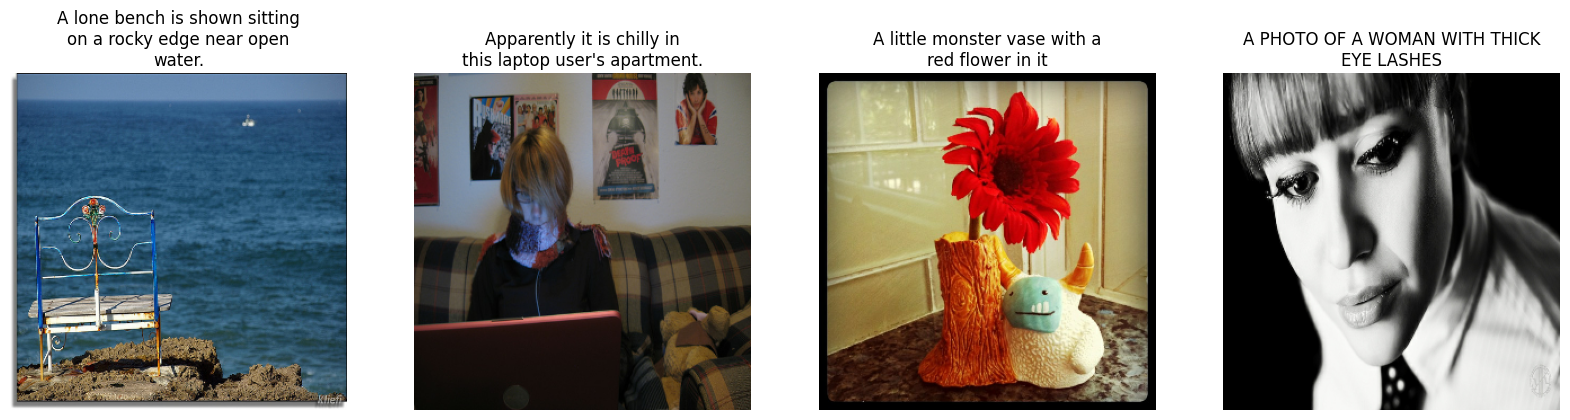

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))  # Plot a 1x4 row of 5x5 images
for idx, data in enumerate(trainds.take(4)):  # Grab 4 images from trainds
  ax[idx].imshow(data["image_tensor"].numpy())  # Render the image here
  caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
  ax[idx].set_title(caption)
  ax[idx].axis("off")

# Text preprocessing
All training text inputted to this model will begin with a start token (string "\<start\>") and end with an end token (string "\<end\>").
<br><br>
This is because this model uses encoding and decoding. \<start\> signifies the beginning of generation and \<end\> tells the model that it stop.

In [ ]:
def add_start_end_token(data):
  start = tf.convert_to_tensor("<start>")
  end = tf.convert_to_tensor("<end>")
  data["caption"] = tf.strings.join(
      [start, data["caption"], end], separator=" "
  )
  return data

trainds = trainds.map(add_start_end_token)

# Tokenizing the captions
Using the `TextVectorization` layer, we will changes captions into integer sequences.
<br><br>
How this is done:
*   `adapt` will iterate through all captions and, based on the words there, compute a vocabulary of size `VOCAB_SIZE` comprised of the most prominent words
*   Captions will be tokenized, i.e. every word will be mapped to an integer (the word's corresponding index in the vocabulary). All outputted captions will be padded to `MAX_CAPTION_LEN`

In [ ]:
MAX_CAPTION_LEN = 64

# Defining a standardize function here to override the typical standardize
# function (and preserve the '<' and '>' characters used in the
# start/end tokens)
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(
    inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
  )

# Remove punctuation and build the vocabulary
tokenizer = TextVectorization(
  max_tokens=VOCAB_SIZE,
  standardize=standardize,
  output_sequence_length=MAX_CAPTION_LEN,
)
tokenizer.adapt(trainds.map(lambda x: x["caption"]))

# Tokenization examples

In [ ]:
# An example of the tokenizer working:
tokenizer(["<start> This is a sentence <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 165,  11,   2,   1,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [ ]:
sample_captions = []
for element in trainds.take(5):
  sample_captions.append(element["caption"].numpy())

In [ ]:
sample_captions

[b'<start> An antique portrait of a man dressed formally <end>',
 b'<start> The man poses with a neck tie while leaning against a tree. <end>',
 b"<start> I hope he doesn't cut his hand with those scissors. <end>",
 b'<start> A huge crowd of people standing on a corner of a very busy intersection.  <end>',
 b'<start> a person sitting on a floor with a laptop <end>']

In [ ]:
print(tokenizer(sample_captions))

tf.Tensor(
[[   3   18 1054 2136    5    2   12  444 3883    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    7   12  778    9    2  592  216   56  473  327    2  127    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3 1147 4279  391 3530  357   50  187    9 2603  372    4    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

In [ ]:
# Converting ids to original text:
wordid = tokenizer([sample_captions[0]])[0][0]
print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> 

In [ ]:
# Making conversions between word and idnex using a StringLookup layer
word_to_index = StringLookup(
  mask_token="", vocabulary=tokenizer.get_vocabulary()
)
index_to_word = StringLookup(
  mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

# Making a tf.data training dataset
Input data will be shifted slightly to the left to allow the model to train on "predicting" what the next word should be.
<br><br>
The dataset will return tuples, in the format (features data, labels).

In [ ]:
BATCH_SIZE = 32

def create_ds_fn(data):
  """
  Make a target prediction for the passed in caption, for the model to
  train with.
  """
  img_tensor = data["image_tensor"]
  caption = tokenizer(data["caption"])

  target = tf.roll(caption, -1, 0)  # Shift the target to the left
  zeros = tf.zeros([1], dtype=tf.int64)
  target = tf.concat((target[:-1], zeros), axis=-1)  # Padding
  return (img_tensor, caption), target

batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
# Examples
for (img, caption), label in batched_ds.take(2):
  print(f"Image shape: {img.shape}")
  print(f"Caption shape: {caption.shape}")
  print(f"Label shape: {label.shape}")
  print(caption[0])
  print(label[0])
  print("\n\n")

Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2  29 690 247 225 109  18 250 309   4   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
tf.Tensor(
[  2  29 690 247 225 109  18 250 309   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)



Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2  43  10  19 190   5  20 381  21   2 160 326   4   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   

# Designing the image encoder
The image encoder will
1.   Extract features from the image using convolutional layers of the pre-trained InceptionResNetV2. This gives us a vector of size (BATCH_SIZE, 8, 8, 1536)
2.   Reshape the vector to size (BATCH_SIZE, 64, 1536)
3.   Squash the vector to size (BATCH_SIZE, 64, ATTENTION_DIM) using a Dense Layer
4.   The Attention layer will later be used to predict the next word


In [ ]:
FEATURE_EXTRACTOR.trainable = False

# Features are extracted from the image into a vector
image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

# Vector is reshaped and squashed
x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
  image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)

In [ ]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55,123,680
Trainable params: 786,944
Non-trainable params: 54,336,736
_________________________________________________________________


# Designing the caption decoder
The decoder is based on an attention mechanism that prioritizes different features of the inputted image.
<br><br>
This implementation uses the Luong-style attention predefined in `layers.Attention`.
<br><br>
The caption decoder will:
1.    Receive the current word tokens as a batch
2.    Embed the word tokens to a dimension of size ATTENTION_DIM
3.    Keep track of the word embeddings through the GRU layer. Returns the GRU output and states
4.    Apply Bahdanau-style attention over the encoder's output vector using the GRU
5.    Applies the attention and GRU outputs as **skip connections** by adding them to the vector. Then the vector is normalized
6.    Generates logit-value predictions for what the next token should be

In [ ]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
  ATTENTION_DIM,
  return_sequences=True,
  return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_atention = Attention()
context_vector = decoder_atention([gru_output, encoder_output])

# Incorporate the attention mechanism
addition = Add()([gru_output, context_vector])

# Normalize the vector after addition
layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

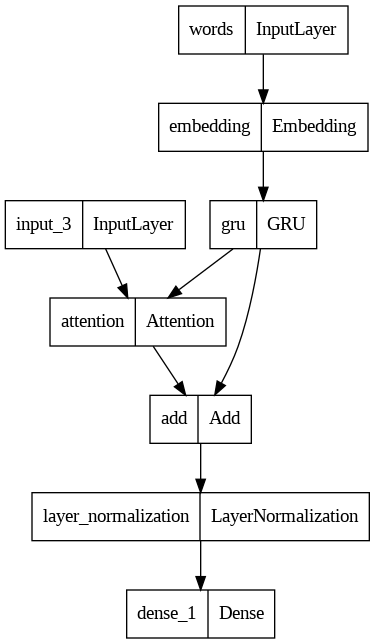

In [ ]:
decoder = tf.keras.Model(
  inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [ ]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words (InputLayer)             [(None, 64)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 64, 512)      10240000    ['words[0][0]']                  
                                                                                                  
 gru (GRU)                      [(None, 64, 512),    1575936     ['embedding[1][0]']              
                                 (None, 512)]                                                     
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 512)]    0           []                         

# Setting up the model

In [ ]:
# Defining the model
image_caption_train_model = tf.keras.Model(
  inputs=[image_input, word_input], outputs=decoder_output
)

# Defining the loss function (cross-entropy, need to remove padding)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
  from_logits=True, reduction="none"
)

def loss_function(real, pred):
  loss_ = loss_object(real, pred)

  # Takes the array and sets each non-zero number to 1
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  mask = tf.cast(mask, dtype=tf.int32)
  sentence_len = tf.reduce_sum(mask)  # Extract the length of the sentence
  loss_ = loss_[:sentence_len]

  return tf.reduce_mean(loss_, 1)

In [ ]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

# Training the model

In [ ]:
%%time
history = image_caption_train_model.fit(batched_ds, epochs=1)

2586/2586 [==============================] - 972s 364ms/step - loss: 0.5669
CPU times: user 15min 23s, sys: 1min 9s, total: 16min 33s
Wall time: 16min 35s


# Captioning something

In [ ]:
# We need to keep track of the trained GRU state, so
# briefly we'll define another model that has the same weights
# (to maintain the GRU state during caption generation)
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

# Reuse the trained GRU, and now allow it to receive states
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other components
context_vector = decoder_atention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)
decoder_output = decoder_output_dense(layer_norm_output)

decoder_pred_model = tf.keras.Model(
  inputs=[word_input, gru_state_input, encoder_output],
  outputs=[decoder_output, gru_state],
)

To get our caption, we'll
1.    Initialize GRU to have a zero vector state
2.    Preprocess the image, pass it into the encoder
3.    Initialize an array of tokens beginning with "\<start\>"
4.    In a for loop:

  *   Pass in the word tokens and status of the model to get decoder predictions
  *   Select which prediction we want to use for the caption with Top-K algorithm
  *   End if we've hit the "\<end\>" token
  *   Replace the current input token with the newly predicted token

In [ ]:
MINIMUM_SENTENCE_LENGTH = 5

def predict_caption(filename):
  """
  Uses probabilities to select predicted caption words from the trained model
  """
  gru_state = tf.zeros((1, ATTENTION_DIM))

  img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  img = img / 255

  features = encoder(tf.expand_dims(img, axis=0))
  dec_input = tf.expand_dims([word_to_index("<start>")], 1)
  result = []

  # For how many words that will be in our caption...
  for i in range(MAX_CAPTION_LEN):
    predictions, gru_state = decoder_pred_model(  # Get predicitions
      [dec_input, gru_state, features]
    )

    # Use Top-K to somewhat randomly pick from a log distribution of
    # the predictions
    top_probs, top_idxs = tf.math.top_k(
      input=predictions[0][0], k=10, sorted=False
    )
    chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
    predicted_id = top_idxs.numpy()[chosen_id][0]

    result.append(tokenizer.get_vocabulary()[predicted_id])

    # End if we've found
    if predicted_id == word_to_index("<end>"):
      return img, result

    dec_input = tf.expand_dims([predicted_id], 1)

  return img, result


--2023-07-04 07:23:51--  https://github.com/max-wild/machine-learning-labs/blob/main/samples/innocuous-cat-2.JPG?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/max-wild/machine-learning-labs/raw/main/samples/innocuous-cat-2.JPG [following]
--2023-07-04 07:23:51--  https://github.com/max-wild/machine-learning-labs/raw/main/samples/innocuous-cat-2.JPG
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/max-wild/machine-learning-labs/main/samples/innocuous-cat-2.JPG [following]
--2023-07-04 07:23:51--  https://raw.githubusercontent.com/max-wild/machine-learning-labs/main/samples/innocuous-cat-2.JPG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubu

(-0.5, 4031.5, 3023.5, -0.5)

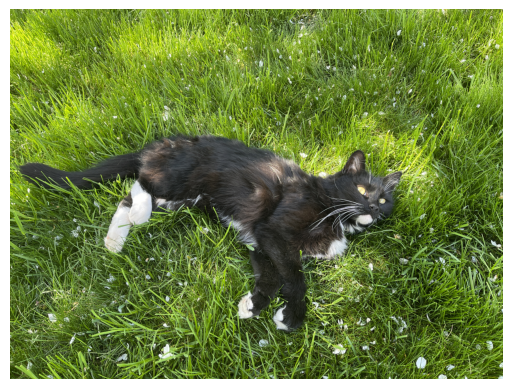

In [81]:
!wget -O "innocuous-cat.jpg" https://github.com/max-wild/machine-learning-labs/blob/main/samples/innocuous-cat-2.JPG?raw=true
filename = "./innocuous-cat.jpg"  # This is my cat :^)

for i in range(2):
  image, caption = predict_caption(filename)  # Generate captions
  print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off")